In [ ]:
import cv2
import numpy as np
import os, random 

def warp_point(x, y, M):
    pt = np.array([[[x, y]]], dtype="float32")
    dst = cv2.perspectiveTransform(pt, M)
    return dst[0][0]

def boxes_overlap(box1, box2, iou_threshold=0.0):
    """Check if two boxes overlap (using IoU)."""
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    inter_xmin = max(x1_min, x2_min)
    inter_ymin = max(y1_min, y2_min)
    inter_xmax = min(x1_max, x2_max)
    inter_ymax = min(y1_max, y2_max)

    if inter_xmax <= inter_xmin or inter_ymax <= inter_ymin:
        return False  # no overlap

    # IoU if threshold
    inter_area = (inter_xmax - inter_xmin) * (inter_ymax - inter_ymin)
    area1 = (x1_max - x1_min) * (y1_max - y1_min)
    area2 = (x2_max - x2_min) * (y2_max - y2_min)
    iou = inter_area / float(area1 + area2 - inter_area)
    return iou > iou_threshold

def paste_and_update_yolo(
    labeled_img_path, yolo_txt_path,
    background, w_bg, h_bg,
    min_size, max_size,
    placed_boxes
):
    # Load labeled image
    labeled_img = cv2.imread(labeled_img_path)
    h_lbl, w_lbl = labeled_img.shape[:2]

    # Load YOLO labels
    with open(yolo_txt_path, "r") as f:
        lines = f.readlines()

    bboxes = []
    for line in lines:
        cls, x, y, w, h = map(float, line.strip().split())
        cx = x * w_lbl
        cy = y * h_lbl
        bw = w * w_lbl
        bh = h * h_lbl
        bboxes.append((int(cls), cx, cy, bw, bh))

    # Scale down
    target_w = random.randint(min_size, min(max_size, w_bg))
    scale = target_w / w_lbl
    target_h = int(h_lbl * scale)
    resized_lbl = cv2.resize(labeled_img, (target_w, target_h))
    scaled_boxes = [(cls, cx*scale, cy*scale, bw*scale, bh*scale) for cls,cx,cy,bw,bh in bboxes]

    # Perspective warp
    rows, cols = resized_lbl.shape[:2]
    pts1 = np.float32([[0,0],[cols,0],[0,rows],[cols,rows]])
    margin = int(min(cols, rows) * 0.2)
    pts2 = np.float32([
        [random.randint(0, margin), random.randint(0, margin)],
        [cols - random.randint(0, margin), random.randint(0, margin)],
        [random.randint(0, margin), rows - random.randint(0, margin)],
        [cols - random.randint(0, margin), rows - random.randint(0, margin)]
    ])
    M = cv2.getPerspectiveTransform(pts1, pts2)
    resized_lbl_rgba = cv2.cvtColor(resized_lbl, cv2.COLOR_BGR2BGRA)
    resized_lbl_rgba[:, :, 3] = 255
    warped_lbl = cv2.warpPerspective(
        resized_lbl_rgba, M, (cols, rows),
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=(0,0,0,0)
    )

    # Warp boxes
    warped_boxes = []
    for cls, cx, cy, bw, bh in scaled_boxes:
        x1,y1 = cx - bw/2, cy - bh/2
        x2,y2 = cx + bw/2, cy - bh/2
        x3,y3 = cx - bw/2, cy + bh/2
        x4,y4 = cx + bw/2, cy + bh/2
        corners = [(x1,y1),(x2,y2),(x3,y3),(x4,y4)]
        warped = [warp_point(x,y,M) for (x,y) in corners]
        xs, ys = [p[0] for p in warped], [p[1] for p in warped]
        x_min, x_max = min(xs), max(xs)
        y_min, y_max = min(ys), max(ys)
        cx_new, cy_new = (x_min+x_max)/2, (y_min+y_max)/2
        bw_new, bh_new = x_max-x_min, y_max-y_min
        warped_boxes.append((cls, cx_new, cy_new, bw_new, bh_new))

    # Find a non-overlapping position
    new_h, new_w = warped_lbl.shape[:2]
    if new_w >= w_bg or new_h >= h_bg:
        scale_factor = min(w_bg / new_w, h_bg / new_h) * 0.9
        warped_lbl = cv2.resize(warped_lbl, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)
        new_h, new_w = warped_lbl.shape[:2]

    for _ in range(50):  # max retries
        x_offset = random.randint(0, w_bg - new_w)
        y_offset = random.randint(0, h_bg - new_h)
        # Candidate box (whole pasted image)
        paste_box = (x_offset, y_offset, x_offset+new_w, y_offset+new_h)

        if all(not boxes_overlap(paste_box, b) for b in placed_boxes):
            # Good placement
            bgr = warped_lbl[:, :, :3]
            alpha = warped_lbl[:, :, 3]
            roi = background[y_offset:y_offset+new_h, x_offset:x_offset+new_w]

            fg = cv2.bitwise_and(bgr, bgr, mask=alpha)
            bg = cv2.bitwise_and(roi, roi, mask=cv2.bitwise_not(alpha))
            background[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = cv2.add(bg, fg)

            final_boxes = []
            for cls, cx, cy, bw, bh in warped_boxes:
                cx += x_offset
                cy += y_offset
                final_boxes.append((cls, cx/w_bg, cy/h_bg, bw/w_bg, bh/h_bg))

            placed_boxes.append(paste_box)
            return background, final_boxes

    print("Could not place object without overlap")
    return background, []


In [2]:
def process_all(background_folder, images_folder, labels_folder, output_folder,
                train_ratio=0.8):
    # Create train/valid subfolders
    for split in ["train", "valid"]:
        os.makedirs(os.path.join(output_folder, split, "images"), exist_ok=True)
        os.makedirs(os.path.join(output_folder, split, "labels"), exist_ok=True)

    bg_files = [os.path.join(background_folder, f) for f in os.listdir(background_folder) 
                if f.endswith((".jpg",".png"))]
    img_files = [f for f in os.listdir(images_folder) if f.endswith(".jpg")]

    for bg_path in bg_files:
        bg = cv2.imread(bg_path)
        bg = cv2.resize(bg, (640, 480))
        h_bg, w_bg = bg.shape[:2]
        composite = bg.copy()
        placed_boxes = []
        all_boxes = []

        num_objs = random.randint(1,3)
        if num_objs == 1:
            min_size, max_size = 50, 480
        else:
            min_size, max_size = 50, 200

        chosen_imgs = random.sample(img_files, num_objs)
        for img_name in chosen_imgs:
            img_path = os.path.join(images_folder, img_name)
            txt_path = os.path.join(labels_folder, img_name.replace(".jpg",".txt"))

            composite, new_boxes = paste_and_update_yolo(
                img_path, txt_path, composite, w_bg, h_bg,
                min_size, max_size, placed_boxes
            )
            all_boxes.extend(new_boxes)

        # Pick split
        split = "train" if random.random() < train_ratio else "valid"

        # Save outputs
        base = os.path.splitext(os.path.basename(bg_path))[0]
        out_img_path = os.path.join(output_folder, split, "images", base+".jpg")
        out_txt_path = os.path.join(output_folder, split, "labels", base+".txt")

        cv2.imwrite(out_img_path, composite)
        with open(out_txt_path, "w") as f:
            for cls, x, y, w, h in all_boxes:
                f.write(f"{cls} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")

        print(f"Done {bg_path} -> {split}")

In [4]:
process_all(
    '../data/backgrounds', 
    '../data/images', 
    '../data/labels', 
    '../data'
)

Done ../data/backgrounds/67eaa5c5b5522203b41a510d_240.jpg -> train
Done ../data/backgrounds/67ea2b35b5522203b419bd16_240.jpg -> valid
Done ../data/backgrounds/67fb768978a804721c5dfd90_240.jpg -> valid
Done ../data/backgrounds/67ea5000b5522203b419dfc8_0.jpg -> train
Done ../data/backgrounds/67eab3d3b5522203b41a72ea_240.jpg -> valid
Done ../data/backgrounds/67ea783eb5522203b41a07f4_240.jpg -> train
Done ../data/backgrounds/67eaaee4b5522203b41a688a_0.jpg -> train
Done ../data/backgrounds/67ea7ef8b5522203b41a10f6_240.jpg -> train
Done ../data/backgrounds/67ea2a27b5522203b419bc3f_240.jpg -> train
Done ../data/backgrounds/67eac47bb5522203b41aabde_0.jpg -> train
Done ../data/backgrounds/67fb94f278a804721ca726ba_0.jpg -> train
Done ../data/backgrounds/67ead502b5522203b41af7c8_0.jpg -> train
Done ../data/backgrounds/67ea3c5bb5522203b419ca9d_120.jpg -> train
Done ../data/backgrounds/67eacf9ab5522203b41ada4b_120.jpg -> train
Done ../data/backgrounds/67ead65eb5522203b41b013f_0.jpg -> train
Done ..

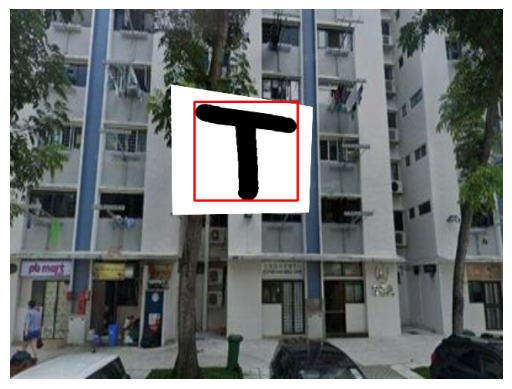

In [6]:
# Display the updated image in the notebook with bounding boxes
import matplotlib.pyplot as plt
import cv2

img = cv2.imread('../data/train/images/67ea1c7fb5522203b419b15a_0.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Read YOLO bboxes from output.txt
h, w = img.shape[:2]
with open('../data/train/labels/67ea1c7fb5522203b419b15a_0.txt', 'r') as f:
    for line in f:
        cls, x, y, bw, bh = map(float, line.strip().split())
        x_center = int(x * w)
        y_center = int(y * h)
        box_w = int(bw * w)
        box_h = int(bh * h)
        x1 = x_center - box_w // 2
        y1 = y_center - box_h // 2
        x2 = x_center + box_w // 2
        y2 = y_center + box_h // 2
        img_rgb = cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)

plt.imshow(img_rgb)
plt.axis('off')
plt.show()

In [ ]:
# Check the size of a background image. rpi camera: (640, 480)
import cv2

background = cv2.imread('backgrounds/67ea1c7fb5522203b419b15a_0.jpg')
height, width = background.shape[:2]
print(f"Background image size: {width} x {height}")
background = cv2.imread('labelled/train/images/1.jpg')
height, width = background.shape[:2]
print(f"Background image size: {width} x {height}")